In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
path = './input/'
file1_name = path + '4135H_2100_SCF_PGS.txt'
plottitle = file1_name + '; Bathymetry: T9; Sources: 4135 at 2100psi and WG5085 at 2100psi'
freq_limit = False
low_freq = False
file2_name = path + 'WG_5085_2100_SI.txt'

In [3]:
f = open(file1_name)
lines = f.read().splitlines()
f.close()
for i, line in enumerate(lines):
    if i < 30:
        print(i, line)

0 FileType : Sound Exposure Level
1 FileVersion : 5
2 SourceKernel : 2.0
3 Routine : Parabolic
4 SEL_window_length(ms) : 10500
5 Azimuth_beg : 90
6 Azimuth_end : 90
7 Azimuth_inc : 40
8 Range_beg : 100
9 Range_end : 50000
10 Range_inc : 100
11 Depth_beg : 20
12 Depth_end : 1000
13 Depth_inc : 20
14 Filter_bool : 0
15 Coordinate_system : Cylindrical
16 Sea_WaterAttn : None
17 Notional_name : 4135H__080_2100_080
18 
19 Azimuth:deg  Range:m  Depth:m  SEL:dB re 1uPa^2 s  
20 90           100      20       183.395             
21 90           100      40       181.898             
22 90           100      60       183.199             
23 90           100      80       183.802             
24 90           100      100      183.941             
25 90           100      120      184.025             
26 90           100      140      183.836             
27 90           100      160      183.469             
28 90           100      180      183.032             
29 90           100      200    

In [4]:
df = pd.DataFrame()

In [5]:
len(df)

0

In [6]:
column_names = ['Azimuth', 'Range', 'Depth', 'SEL']

In [7]:
if freq_limit:
    rowstoskip = 25
    minval = 120
    maxval = 170
    if low_freq:
        minval = 130
        maxval = 190
else:
    rowstoskip = 20
    minval = 130
    maxval = 190

In [8]:
df_raw = pd.read_csv(file1_name, names=column_names, skiprows=rowstoskip, delim_whitespace=True)

In [9]:
df_raw.drop(['Azimuth'], axis=1, inplace=True)

In [10]:
df_reverse_raw = pd.read_csv(file2_name, names=column_names, skiprows=rowstoskip, delim_whitespace=True)
df_reverse_raw.drop(['Azimuth'], axis=1, inplace=True)

Limit the input offset:

In [11]:
df = df_raw[df_raw['Range'] <= 40000]
df_reverse = df_reverse_raw[df_reverse_raw['Range'] <= 40000]

In [12]:
df_pivot = df.pivot(index='Depth', columns='Range', values='SEL')

In [13]:
#df_pivot

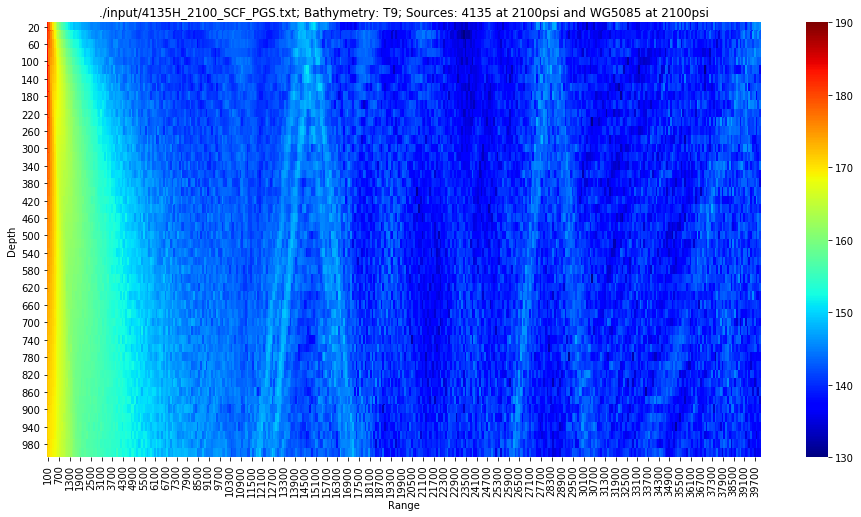

In [14]:
plt.figure(figsize=(16,8))
plt.title(plottitle)
sns.heatmap(df_pivot, cmap='jet', vmin=minval, vmax=maxval)
plt.savefig('1.png'); 

In [15]:
#df

In [16]:
#def mirror_data(data):
#    data_temp = data[['Range']]
#    data_temp_sort = data_temp.sort_values(by=['Range'], ascending=False).reset_index(drop=True)
#    data = data.join(data_temp_sort, rsuffix='-mirror') 
#    return data
    

In [17]:
#data_mirror = mirror_data(df)

In [18]:
#data_mirror

In [19]:
def data_mirror_zero(data):
    data_negative = data.copy(deep=True)
    data_zero_offset = data.loc[data['Range'] == 100].reset_index(drop=True)
    data_zero_offset['Range'] = 0
    #print(data_zero_offset)
    data_negative['Range'] = data_negative['Range'].apply(np.negative)
    data_negative_sort = data_negative.sort_values(by=['Range','Depth'])#.reset_index(drop=True)
    combined_data = pd.concat([data_negative_sort, data_zero_offset, data]).reset_index(drop=True)
    return combined_data

In [20]:
df_mirror = data_mirror_zero(df)

In [21]:
df_reverse_mirror = data_mirror_zero(df_reverse)

In [22]:
df_mirror_pivot = df_mirror.pivot(index='Depth', columns='Range', values='SEL')

In [23]:
df_mirror_pivot.columns

Int64Index([-40000, -39900, -39800, -39700, -39600, -39500, -39400, -39300,
            -39200, -39100,
            ...
             39100,  39200,  39300,  39400,  39500,  39600,  39700,  39800,
             39900,  40000],
           dtype='int64', name='Range', length=801)

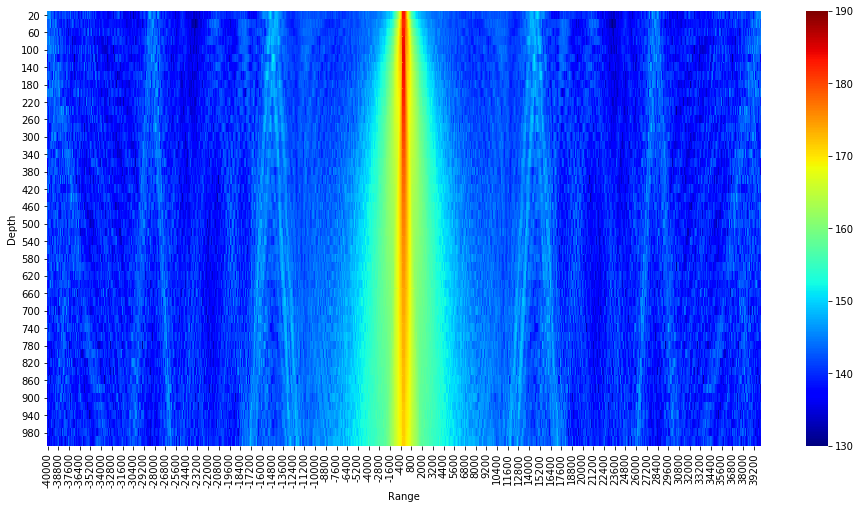

In [24]:
plt.figure(figsize=(16,8))
sns.heatmap(df_mirror_pivot, cmap='jet', vmin=minval, vmax=maxval); 

In [25]:
def shift_and_limit(data, shift, minval, maxval):
    data['Range'] = data['Range'] + shift
    data_limit = data.loc[(data['Range'] >= minval) & (data['Range'] <= maxval)].reset_index(drop=True)
    return data_limit

In [26]:
df_mirror_shift = shift_and_limit(df_mirror, 10000, 100, 40000)

In [27]:
df_mirror_shift_pivot = df_mirror_shift.pivot(index='Depth', columns='Range', values='SEL')

In [28]:
#df_mirror_shift_pivot

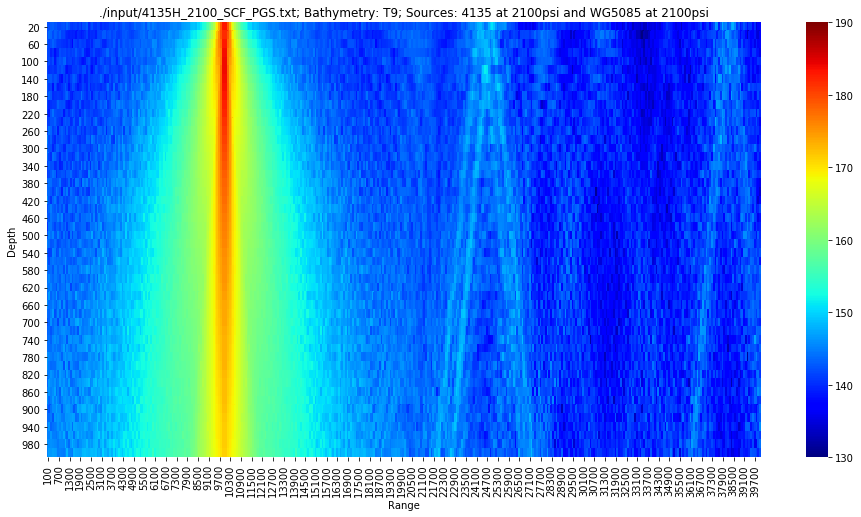

In [29]:
plt.figure(figsize=(16,8))
plt.title(plottitle)
sns.heatmap(df_mirror_shift_pivot, cmap='jet', vmin=minval, vmax=maxval)
plt.savefig('2.png'); 

In [30]:
len(df_mirror_shift)

20000

In [31]:
#df_merge = df.merge(df_mirror_shift, left_on='Range', right_on='Range')
df_merged = df.join(df_mirror_shift, rsuffix='-shift')    

In [32]:
#df_merged

In [33]:
def dB_sum(amp1, amp2):
    x = amp1/10
    y = amp2/10
    amp_comb = 10*np.log10(10**x + 10**y)
    return amp_comb 

In [34]:
print(dB_sum(182.568, 145.683))

182.56888969228777


In [35]:
df_merged['SEL_sum'] = df_merged.apply(lambda x: dB_sum(x.SEL, x['SEL-shift']), axis=1)

In [36]:
#df_merged

In [37]:
df_merged_pivot = df_merged.pivot(index='Depth', columns='Range', values='SEL_sum')

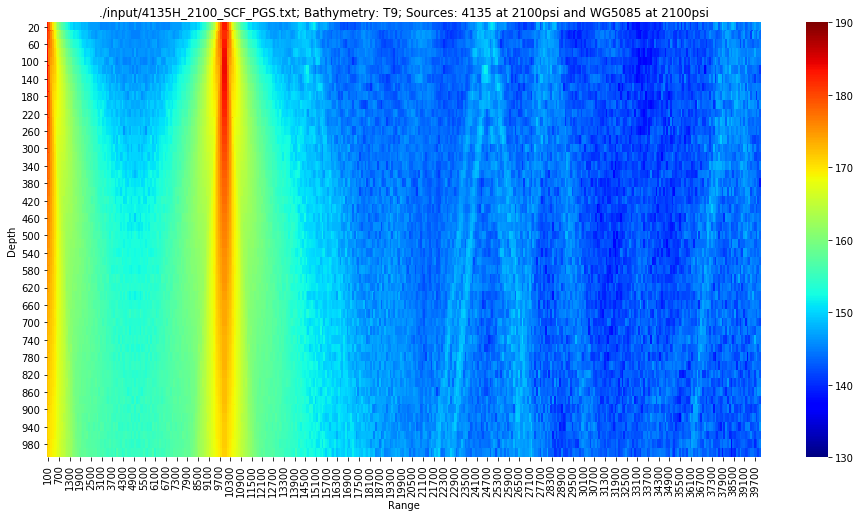

In [38]:
plt.figure(figsize=(16,8))
plt.title(plottitle)
sns.heatmap(df_merged_pivot, cmap='jet', vmin=minval, vmax=maxval)
plt.savefig('3.png'); 

In [39]:
#df_SI = shift_and_limit(df_mirror, 40000, 100, 50000)

In [40]:
df_SI = shift_and_limit(df_reverse_mirror, 40000, 100, 40000)

In [41]:
df_SI_pivot = df_SI.pivot(index='Depth', columns='Range', values='SEL')

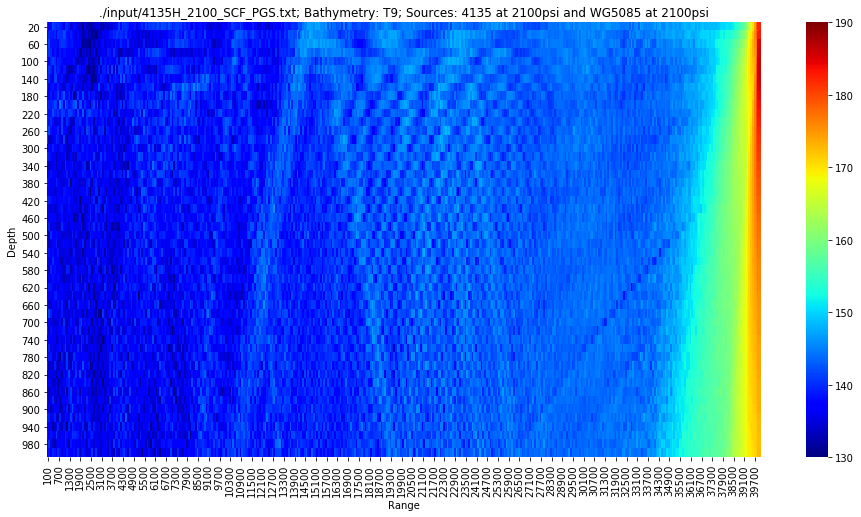

In [42]:
plt.figure(figsize=(16,8))
plt.title(plottitle)
sns.heatmap(df_SI_pivot, cmap='jet', vmin=minval, vmax=maxval)
plt.savefig('4.png'); 

In [43]:
df_SI_merged = df.join(df_SI, rsuffix='-shift') 

In [44]:
df_SI_merged['SEL_sum'] = df_SI_merged.apply(lambda x: dB_sum(x.SEL, x['SEL-shift']), axis=1)

In [45]:
df_SI_merged_pivot = df_SI_merged.pivot(index='Depth', columns='Range', values='SEL_sum')

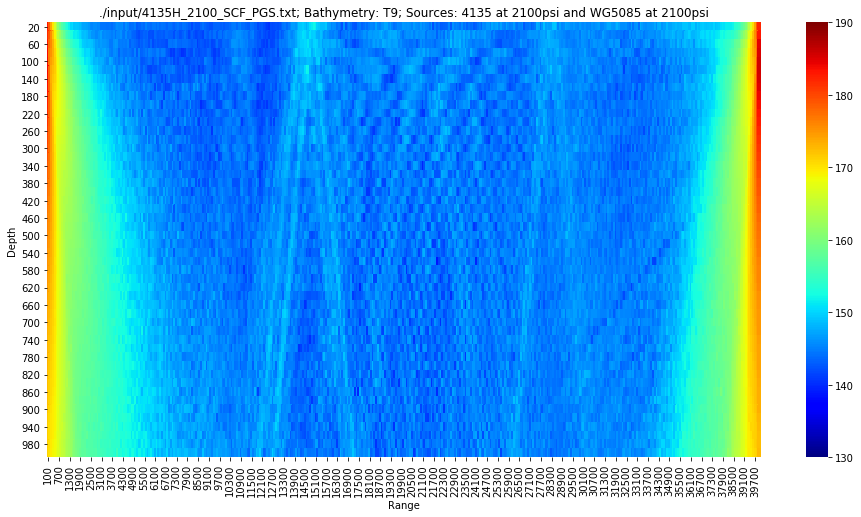

In [46]:
plt.figure(figsize=(16,8))
plt.title(plottitle)
sns.heatmap(df_SI_merged_pivot, cmap='jet', vmin=minval, vmax=maxval)
plt.savefig('5.png'); 

In [47]:
#df_merged

In [48]:
df_CLO_SI_merged = df_merged.join(df_SI, rsuffix='-shift2')

In [49]:
df_CLO_SI_merged['SEL_SI_CLO_sum'] = df_CLO_SI_merged.apply(lambda x: dB_sum(x.SEL_sum, x['SEL-shift2']), axis=1)

In [50]:
df_CLO_SI_merged_pivot = df_CLO_SI_merged.pivot(index='Depth', columns='Range', values='SEL_SI_CLO_sum')

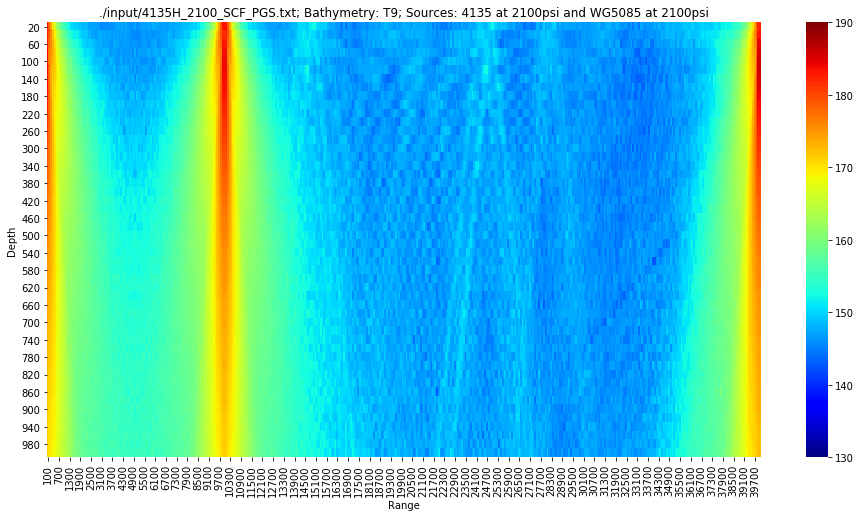

In [51]:
plt.figure(figsize=(16,8))
plt.title(plottitle)
sns.heatmap(df_CLO_SI_merged_pivot, cmap='jet', vmin=minval, vmax=maxval)
plt.savefig('6.png'); 

In [52]:
df_CLO_SI_merged_shallow = df_CLO_SI_merged.loc[df_CLO_SI_merged['Depth'] == 20].reset_index(drop=True)
df_SI_merged_shallow = df_SI_merged.loc[df_SI_merged['Depth'] == 20].reset_index(drop=True)
df_merged_shallow = df_merged.loc[df_merged['Depth'] == 20].reset_index(drop=True)
df_shallow = df.loc[df['Depth'] == 20].reset_index(drop=True)

In [53]:
sns.set_style("darkgrid")
sns.set_context("notebook")

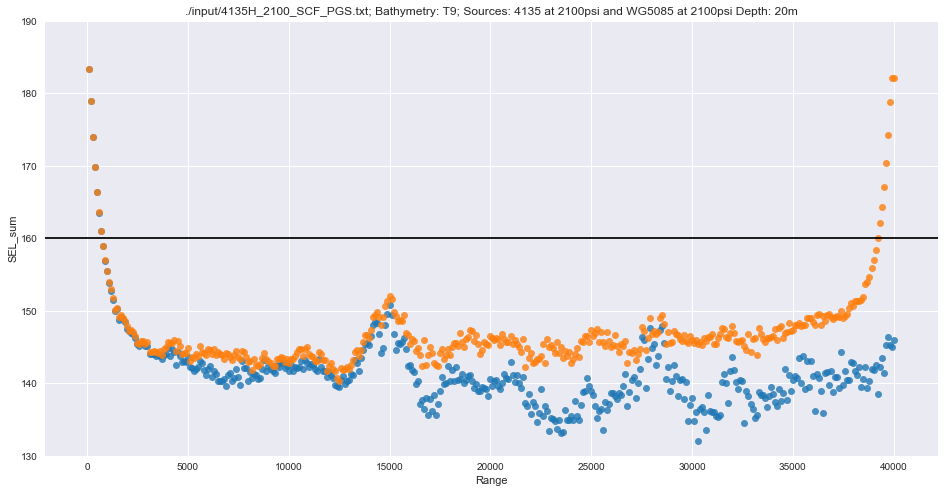

In [54]:
plt.figure(figsize=(16,8))
plt.title(plottitle + ' Depth: 20m')
plt.axhline(160, color='black')
plt.ylim(minval, maxval)
sns.regplot(x=df_shallow['Range'], y=df_shallow['SEL'], fit_reg=False)
#sns.regplot(x=df_merged_shallow['Range'], y=df_merged_shallow['SEL_sum'], fit_reg=False)
sns.regplot(x=df_SI_merged_shallow['Range'], y=df_SI_merged_shallow['SEL_sum'], fit_reg=False)
#sns.regplot(x=df_CLO_SI_merged_shallow['Range'], y=df_CLO_SI_merged_shallow['SEL_SI_CLO_sum'], fit_reg=False)
plt.savefig('7.png'); 

In [55]:
df_CLO_SI_merged_middepth = df_CLO_SI_merged.loc[df_CLO_SI_merged['Depth'] == 1000].reset_index(drop=True)
df_SI_merged_middepth = df_SI_merged.loc[df_SI_merged['Depth'] == 1000].reset_index(drop=True)
df_merged_middepth = df_merged.loc[df_merged['Depth'] == 1000].reset_index(drop=True)
df_middepth = df.loc[df['Depth'] == 1000].reset_index(drop=True)

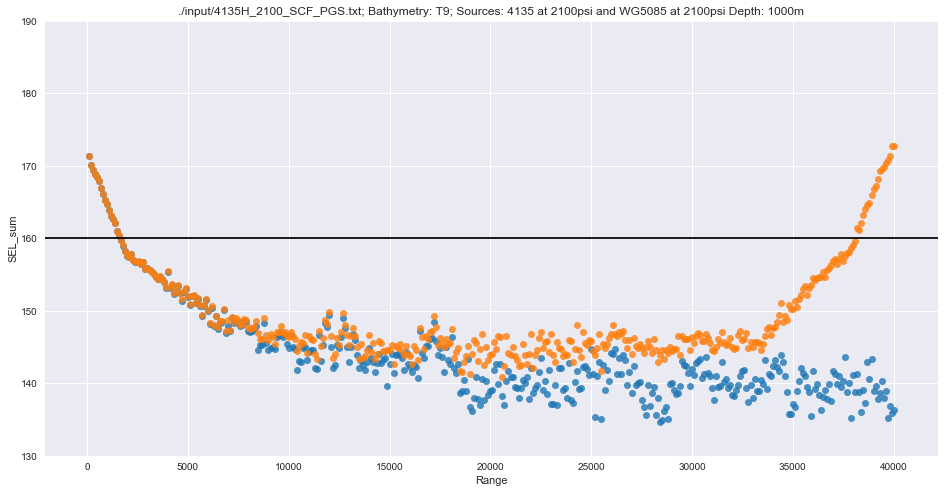

In [56]:
plt.figure(figsize=(16,8))
plt.title(plottitle + ' Depth: 1000m')
plt.axhline(160, color='black')
plt.ylim(minval, maxval)
sns.regplot(x=df_middepth['Range'], y=df_middepth['SEL'], fit_reg=False)
#sns.regplot(x=df_merged_middepth['Range'], y=df_merged_middepth['SEL_sum'], fit_reg=False)
sns.regplot(x=df_SI_merged_middepth['Range'], y=df_SI_merged_middepth['SEL_sum'], fit_reg=False)
#sns.regplot(x=df_CLO_SI_merged_middepth['Range'], y=df_CLO_SI_merged_middepth['SEL_SI_CLO_sum'], fit_reg=False)
plt.savefig('8.png'); 

In [57]:
r = np.random.rand()
beta = r*0.09 + 0.9 

In [58]:
beta

0.9034278807870733

In [59]:
r = np.random.rand()
beta = 1-10**(- r - 1)

In [60]:
beta

0.9807001018758246

In [61]:
r = np.random.rand()
beta = 1-10**(- r + 1)

In [62]:
beta

-0.07242295083793326

In [63]:
r = np.random.rand()
beta = r*0.9 + 0.09 

In [64]:
beta

0.5288768472795589